In [ ]:
#C'est ici que toute la documentation du pipeline, les résultats et les analyses visuelles sont intégrés.
#Ce notebook contient les explications et appelle les scripts du dossier src/ pour exécuter chaque étape du pipeline.
#On l'utilise pour charger et exécuter le pipeline étape par étape. 
#Par exemple, pour exécuter la partie nettoyage, importer et exécuter data_preprocessing.py depuis src/.
#À chaque étape (nettoyage, analyse des données, visualisations), ajouter des cellules Markdown dans le notebook pour expliquer ce que fait chaque étape, pourquoi elle est nécessaire, et les observations tirées des résultats.
#C’est également ici que nous ajouterons les graphiques et analyses visuelles pour expliquer nos résultats intermédiaires.

In [1]:
#Expliquer ce que l'on fait dans notre projet et que pour ce faire nous utiliserons une version clean de movie_metadata.
#On affiche à partir de quelle année notre base de données de films commence pour exclure les évènements historiques trop lointains dans notre dataset additionnel.
#On veut garder la première colonne pour relier le film à son résumé mais aussi la plupart des autres.
#On veut transformer les formats de dates pour l’analyse temporelle.

# ADA Project - Milestone 2

First and foremost, we must setup the environment with the installation of appropriate libraries. 

In [75]:
from tests.test_data_preprocessing import test_cleaned_movie_data
import matplotlib.pyplot as plt 
import pandas as pd
import ast
import numpy as np
import seaborn as sns
#from src.data.preprocess import boxplot

Before beginning our study, we must proceed with data wrangling, transforming raw data into a structured and usable format for analysis.
This includes associating the correct names to our columns, removing outliers, nan and abherrent values and structuring our data so that it may be easier to work with. 

## 1 - Data Collection

We begin with an initial overview of the raw imported data

In [31]:
raw_movies_data = pd.read_csv("data/MovieSummaries/movie.metadata.tsv", header= None, delimiter='\t') # Columns are separated by tabs rather than commas
print("The initial dataframe has ", len(raw_movies_data), "lines.")

The initial dataframe has  81741 lines.


In [32]:
raw_movies_data.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


## 2 - Data Cleaning 

At the first steps of our analysis, we must name the columns for clarity and remove abherrent as well as nan values.

In [41]:
headers = ["Wikipedia movie ID",
    "Freebase movie ID",
    "Movie name",
    "Movie release date",
    "Movie box office revenue",
    "Movie runtime",
    "Movie languages (Freebase ID:name tuples)",
    "Movie countries (Freebase ID:name tuples)",
    "Movie genres (Freebase ID:name tuples)"]
raw_movies_data.columns = headers

### Handling missing values

We can use a heatmap to visualize the missing values from our raw data. Each white line corresponds to a missing value. The columns 'Movie release date', 'Movie box office revenue' and 'Movie runtime' contain a number of missing values. Let's quantify them :

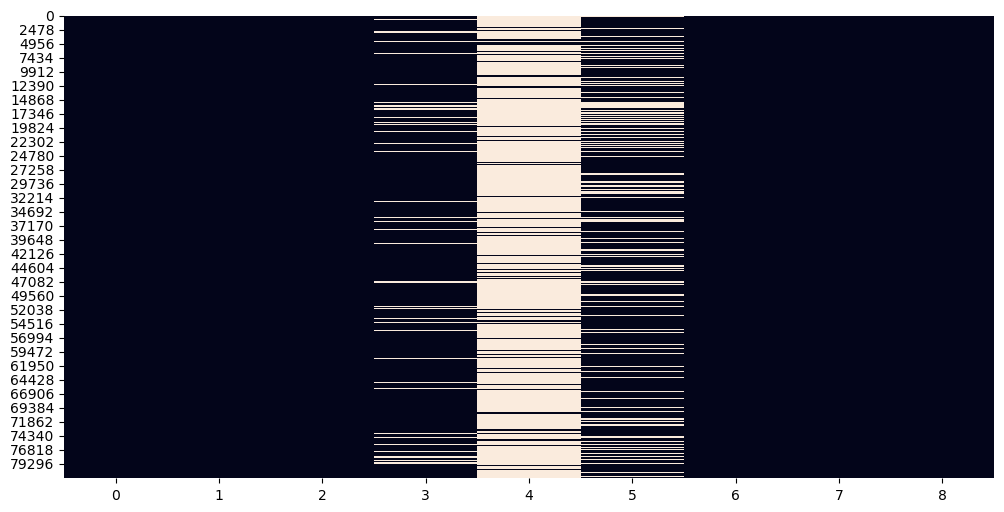

In [36]:
plt.figure(figsize=(12, 6))
sns.heatmap(raw_movies_data.isnull(), cbar=False)
plt.show()

In [45]:
#compute the percetentage of missing values for each column
nb_missing_values = raw_movies_data.isnull().sum().sort_values(ascending=False)
missing_values_percentage = (raw_movies_data.copy().isnull().mean() * 100).sort_values(ascending=False)
#display in a dataframe
missing_values_df = pd.DataFrame({
    'Missing values': nb_missing_values,
    'Percentage (%)': missing_values_percentage
})
print(missing_values_df)

                                           Missing values  Percentage (%)
Movie box office revenue                            73340       89.722416
Movie runtime                                       20450       25.018045
Movie release date                                   6902        8.443743
Wikipedia movie ID                                      0        0.000000
Freebase movie ID                                       0        0.000000
Movie name                                              0        0.000000
Movie languages (Freebase ID:name tuples)               0        0.000000
Movie countries (Freebase ID:name tuples)               0        0.000000
Movie genres (Freebase ID:name tuples)                  0        0.000000


Almost 90% of the movies are missing the information about the box office revenue, thus we cannot drop the rows with missing value in this column.

### Handling outliers

Now that we've looked at missing values, it is time to assess for outliers and abherrent values from our data. 

#### > Movie runtime

In [49]:
raw_movies_data['Movie runtime'].describe()

count    6.129100e+04
mean     1.118192e+02
std      4.360070e+03
min      0.000000e+00
25%      8.100000e+01
50%      9.300000e+01
75%      1.060000e+02
max      1.079281e+06
Name: Movie runtime, dtype: float64

From the boxplot and statistical description of this variable, we observe that the maximum and minimum values are outliers. We may remove them for our analysis using a certain threshold range with which we want to work with (we have a lot of values and we dont necessarily need to deal with these expections) as they only represent approximately 6% of all values.

In [67]:
#Ca c'est a mettre dans un autre fichier mais j'arrive pas, jsuis une merde
def boxplot(data, title):
    plt.figure(figsize=(8, 4))
    plt.boxplot(data.dropna(), vert=False)
    plt.title(title)
    plt.xlabel('Movie runtime')
    plt.show()
    
def outliers_bounds(data, low_factor, up_factor):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - low_factor * IQR
    upper_bound = Q3 + up_factor * IQR
    return lower_bound, upper_bound

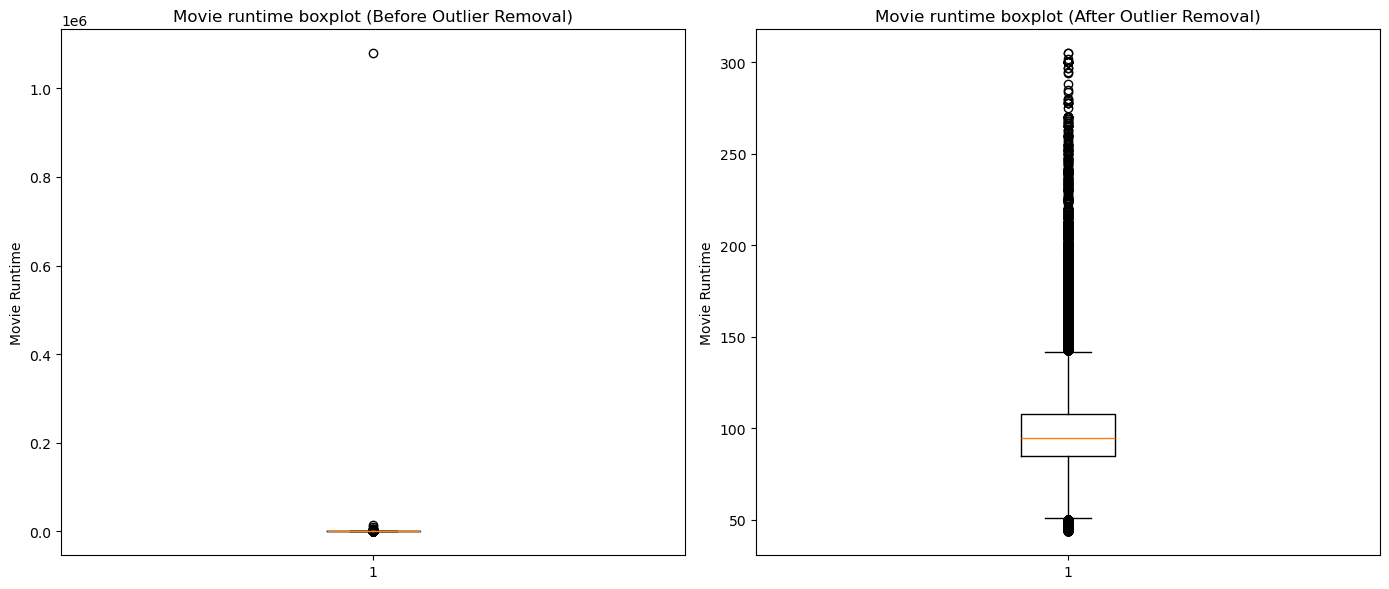

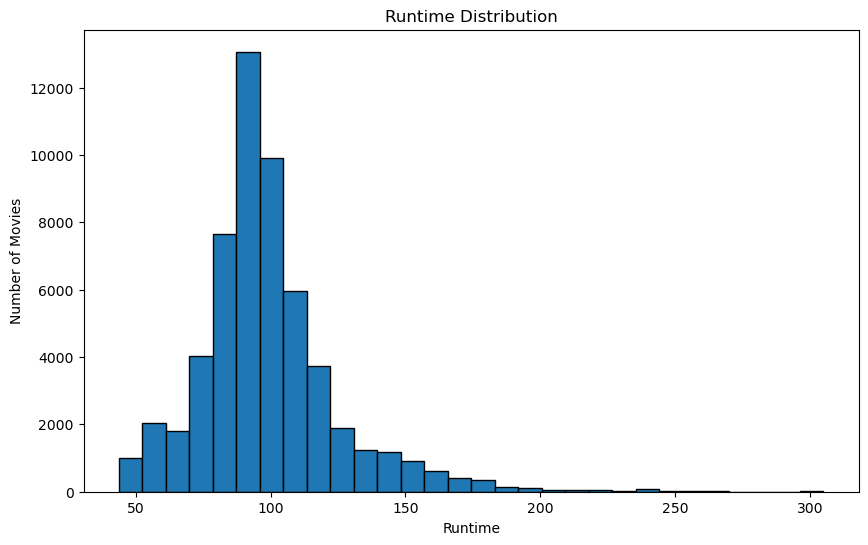

count    56418.000000
mean        98.828453
std         26.285776
min         43.716667
25%         85.000000
50%         95.000000
75%        108.000000
max        305.000000
Name: Movie runtime, dtype: float64

In [70]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming runtime_data, raw_movies_data, and outliers_bounds are defined in your code
# Create a figure with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Boxplot before outlier removal
ax[0].boxplot(runtime_data.dropna())
ax[0].set_title('Movie runtime boxplot (Before Outlier Removal)')
ax[0].set_ylabel('Movie Runtime')

# Boxplot after outlier removal
ax[1].boxplot(clean_movies_data['Movie runtime'])
ax[1].set_title('Movie runtime boxplot (After Outlier Removal)')
ax[1].set_ylabel('Movie Runtime')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

# For the histogram
plt.figure(figsize=(10, 6))
plt.hist(clean_movies_data['Movie runtime'], bins=30, edgecolor='black')
plt.title('Runtime Distribution')
plt.xlabel('Runtime')
plt.ylabel('Number of Movies')
plt.show()

# Return the descriptive statistics for the cleaned data
clean_movies_data['Movie runtime'].describe()


#### > Box Office

In [69]:
raw_movies_data['Movie box office revenue'].describe()

count    8.401000e+03
mean     4.799363e+07
std      1.121753e+08
min      1.000000e+04
25%      2.083193e+06
50%      1.063969e+07
75%      4.071696e+07
max      2.782275e+09
Name: Movie box office revenue, dtype: float64

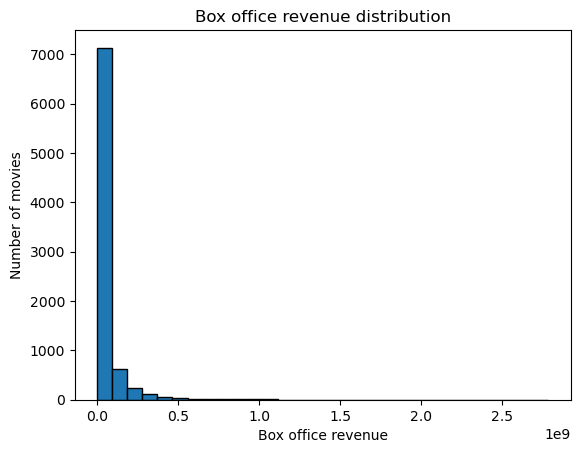

In [71]:
#Box office revenue distribution
plt.figure()
plt.hist(clean_movies_data['Movie box office revenue'], bins=30, edgecolor='black')
plt.title('Box office revenue distribution')
plt.xlabel('Box office revenue')
plt.ylabel('Number of movies')
plt.show()

In [72]:
top_10_box_office = raw_movies_data.sort_values(by='Movie box office revenue', ascending=False).head(10)
top_10_box_office

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples)
23702,4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
22256,52371,/m/0dr_4,Titanic,1997-11-01,2.185372e+09,194.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/0fx2s"": ""Tragedy"", ""/m/04xvh5"": ""Costume ..."
28192,22114132,/m/062zm5h,The Avengers,2012-04-11,1.511758e+09,137.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ..."
30278,31941988,/m/0gvsynb,Harry Potter and the Deathly Hallows – Part 2,2011-07-07,1.328111e+09,130.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/07s9rl0"": ""Drama"", ""/m/02n4kr"": ""Mystery""..."
18645,25001260,/m/0872p_c,Transformers: Dark of the Moon,2011-06-23,1.123747e+09,157.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie..."
80920,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj..."
54719,29075630,/m/0bpm4yw,The Dark Knight Rises,2012-07-16,1.078009e+09,165.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th..."
69586,1213838,/m/04hwbq,Toy Story 3,2010-06-12,1.063172e+09,102.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/03k9fj"": ""Adventure"", ""/m/0hj3myq"": ""Chil..."
14303,24314116,/m/09v8clw,Pirates of the Caribbean: On Stranger Tides,2011-05-07,1.043872e+09,136.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02qvnvs"": ""Swashbuckler films"", ""/m/03k9f..."
50039,50793,/m/0ddt_,Star Wars Episode I: The Phantom Menace,1999-05-19,1.027045e+09,136.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ..."


There does not seem to be any significant outliers in this variable. This is reassuring because we are already quite limited in terms of number of instances as there are a great number of missing values for it.

### > Extra-preprocessing steps

As extra pre-processing steps to prep the data, we removed the films which had no genres indicated as they cannot contribute to our study. This is feasable as only a small number of movies had not genres.
We also removed the "Wikipedia movie ID" and "Freebase movie ID" columns as they had no contribution to our study.

In [80]:
preprocessed_movies = pd.read_csv("data/preprocessed_data/preprocessed_movie_metadata.csv")
print("The dataframe following preprocessing steps has ", len(preprocessed_movies), "lines.")
print(len(raw_movies_data) - len(preprocessed_movies), " lines were lost following the cleaning steps.")

The dataframe following preprocessing steps has  73077 lines.
8664  lines were lost following the cleaning steps.


In [20]:
preprocessed_movies.head()

,Movie name,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Year
0,Ghosts of Mars,14010832.0,98.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001.0
1,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,English Language,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000.0
2,Brun bitter,NaN,83.0,Norwegian Language,Norway,"Crime Fiction, Drama",1988.0
3,White Of The Eye,NaN,110.0,English Language,United Kingdom,"Thriller, Erotic thriller, Psychological thriller",1987.0
4,A Woman in Flames,NaN,106.0,German Language,Germany,Drama,1983.0


In [22]:
preprocessed_movies.describe()

,Movie box office revenue,Movie runtime,Year
count,8.323000e+03,5.820600e+04,73076.000000
mean,4.828817e+07,1.124090e+02,1977.445536
std,1.124909e+08,4.473623e+03,29.019725
min,1.000000e+04,0.000000e+00,1888.000000
25%,2.102500e+06,8.100000e+01,1955.000000
50%,1.082781e+07,9.300000e+01,1985.000000
75%,4.113620e+07,1.060000e+02,2004.000000
max,2.782275e+09,1.079281e+06,2016.000000


## 3 - Preliminary Data Analysis

#### Number of film of year

It is important to note for our future analysis that the number of films produced each year is not uniform. This variability should be considered when comparing film counts over time. In some cases, working with proportions rather than absolute numbers may provide us more interesting insights.


Text(0.5, 1.0, 'Number of movies per year')

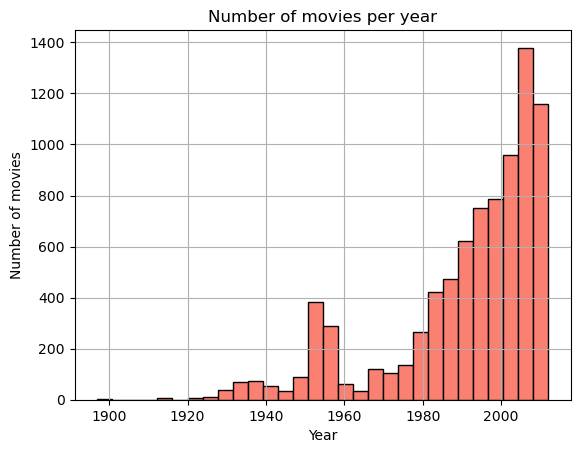

In [148]:
preprocessed_movies["Year"].hist(bins=30, range=(preprocessed_movies["Year"].min(), preprocessed_movies["Year"].max()), color = 'salmon', edgecolor = 'black')
plt.xlabel("Year")
plt.ylabel("Number of movies")
plt.title("Number of movies per year")

# Genre Movie exploring

In [149]:
#Number of genres in the dataset but we can see that there are a lot of categories that could be combined
genres = preprocessed_movies['Movie genres'].str.split(', ').explode().unique()
print(len(genres),genres)

311 ['Thriller' 'Science Fiction' 'Horror' 'Adventure' 'Supernatural' 'Action'
 'Space western' 'Musical' 'Comedy' 'Black-and-white' 'Costume drama'
 'War film' 'Epic' 'Period piece' 'Drama' 'Film adaptation'
 "Children's/Family" 'Fantasy' 'Family Film' "Children's Fantasy"
 'Future noir' 'Indie' 'Erotic thriller' 'Crime Fiction' 'Coming of age'
 'Romance Film' 'Marriage Drama' 'Action/Adventure' 'World cinema' 'Cult'
 'Adventure Comedy' 'Slapstick' 'Sports' 'Family Drama' 'Comedy-drama'
 'Ensemble Film' 'Romantic comedy' 'Short Film' 'Epic Western' 'Western'
 'Silent film' 'Mystery' 'Crime Thriller' 'Satire' 'Legal drama'
 'Courtroom Drama' 'New Hollywood' 'Suspense' 'Romantic drama' 'Biography'
 'Biopic [feature]' 'Biographical film' 'Musical Drama' 'Crime Comedy'
 'Gangster Film' 'Monster movie' 'Natural horror films' 'B-movie'
 'Creature Film' 'Slasher' 'Music' 'Comedy of Errors' 'Americana' 'LGBT'
 'Teen' 'Escape Film' 'Prison' 'Superhero movie' 'Wuxia'
 'Fantasy Adventure' 'Marti

There are 363 different genres, many genres are used to described the film. Here a genre regroup a lot of information: the thematic, the technical characteristics, ... 
Clearly, not all of these information are useful for our analysis. We need to select to best to regroup the film in a meaningful way.

## Petite tentative pour observer les war movies

In [150]:
War_movies = preprocessed_movies[preprocessed_movies['Movie genres'].str.contains(r'war', case=False, na=False)]
War_movies_comedy = War_movies[War_movies['Movie genres'].str.contains(r'comedy', case=False, na=False)]
War_movies_drama = War_movies[War_movies['Movie genres'].str.contains(r'drama', case=False, na=False)]
print(len(War_movies), len(War_movies_comedy), len(War_movies_drama))

418 57 340


Text(0.5, 1.0, 'Number of movies per year')

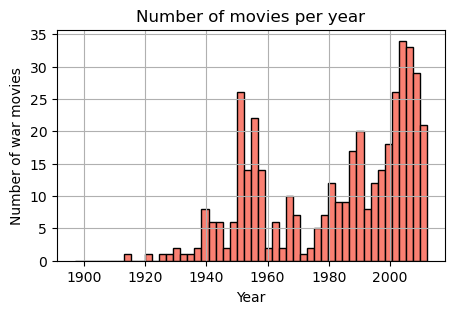

In [151]:
plt.figure(figsize=(5,3))
War_movies["Year"].hist(bins=50, range=(preprocessed_movies["Year"].min(), preprocessed_movies["Year"].max()), color = 'salmon', edgecolor = 'black')

plt.xlabel("Year")
plt.ylabel("Number of war movies")
plt.title("Number of movies per year")

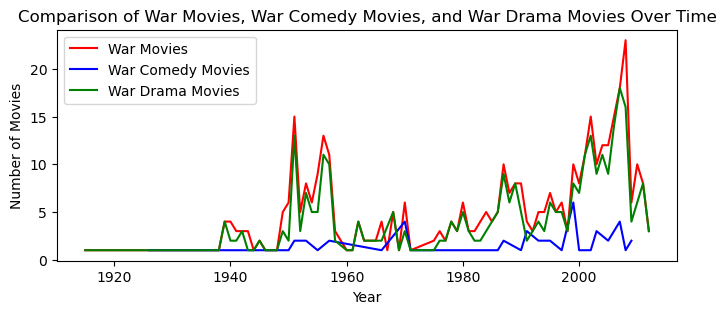

In [152]:
plt.figure(figsize=(8, 3))

# Count the number of movies in each category per year
war_movies_per_year = War_movies.groupby('Year').size()
war_comedy_movies_per_year = War_movies_comedy.groupby('Year').size()
war_drama_movies_per_year = War_movies_drama.groupby('Year').size()

# Plot the data
plt.plot(war_movies_per_year.index, war_movies_per_year.values, label='War Movies', color='red')
plt.plot(war_comedy_movies_per_year.index, war_comedy_movies_per_year.values, label='War Comedy Movies', color='blue')
plt.plot(war_drama_movies_per_year.index, war_drama_movies_per_year.values, label='War Drama Movies', color='green')

plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Comparison of War Movies, War Comedy Movies, and War Drama Movies Over Time')
plt.legend()
plt.show()



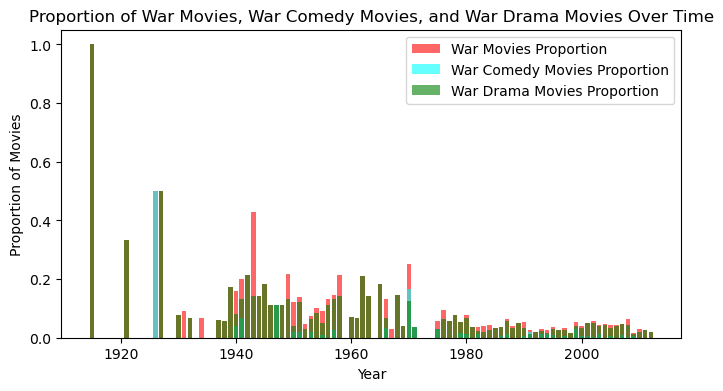

In [153]:
total_movies_per_year = preprocessed_movies.groupby('Year').size()

# Calculate the proportion of each category of movie per year
war_movies_proportion = war_movies_per_year / total_movies_per_year
war_comedy_movies_proportion = war_comedy_movies_per_year / total_movies_per_year
war_drama_movies_proportion = war_drama_movies_per_year / total_movies_per_year

plt.figure(figsize=(8, 4))
plt.bar(war_movies_proportion.index, war_movies_proportion.values, label='War Movies Proportion', color='red', alpha=0.6)
plt.bar(war_comedy_movies_proportion.index, war_comedy_movies_proportion.values, label='War Comedy Movies Proportion', color='cyan', alpha=0.6)
plt.bar(war_drama_movies_proportion.index, war_drama_movies_proportion.values, label='War Drama Movies Proportion', color='green', alpha=0.6)

plt.xlabel('Year')
plt.ylabel('Proportion of Movies')
plt.title('Proportion of War Movies, War Comedy Movies, and War Drama Movies Over Time')
plt.legend(loc='upper right')
plt.show()

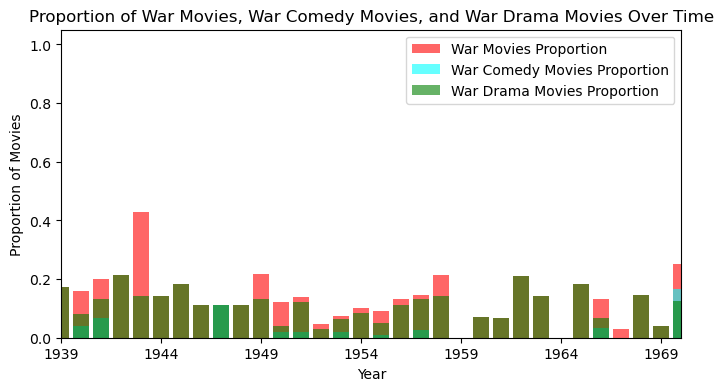

In [154]:
plt.figure(figsize=(8, 4))
plt.bar(war_movies_proportion.index, war_movies_proportion.values, label='War Movies Proportion', color='red', alpha=0.6)
plt.bar(war_comedy_movies_proportion.index, war_comedy_movies_proportion.values, label='War Comedy Movies Proportion', color='cyan', alpha=0.6)
plt.bar(war_drama_movies_proportion.index, war_drama_movies_proportion.values, label='War Drama Movies Proportion', color='green', alpha=0.6)

plt.xlabel('Year')
plt.xlim(1939, 1970)
plt.xticks(np.arange(1939, 1971, 5))
plt.ylabel('Proportion of Movies')
plt.title('Proportion of War Movies, War Comedy Movies, and War Drama Movies Over Time')
plt.legend(loc='upper right')
plt.show()

## fin mini war movie analysis youhouu


Enfin, on veut clean notre dataset additionnel, création de catégories utiles pour l’analyse, comme « guerre », « crise économique », « période de stabilité ». On cherche encore ici à vectoriser et mettre sous forme de token certains types de mots en identifiant les catégories qui nous intéressent.
On veut éliminer les valeurs manquantes ainsi que les événements historiques beaucoup trop vieux pour notre analyse.
Peu importe la méthode utilisée pour tokeniser/vectroriser, expliquer ici pourquoi c'est approprié pour nos objectif et donner une  brève explication mathématique si possible.
On veut aussi transformer les formats de dates pour l’analyse temporelle à l'image de notre movie dataset.

In [155]:
from tests.test_data_preprocessing import test_cleaned_historical_data, test_vectorized_historical_data
import pandas as pd

history_data = pd.read_csv("data/HistoricalDataset/historical.dataset.csv")
history_data.head()

,Sl. No,Name of Incident,Date,Month,Year,Country,Type of Event,Place Name,Impact,Affected Population,Important Person/Group Responsible,Outcome
0,1,Indus Valley Civilization Flourishes,Unknown,Unknown,2600 BC,India,Civilization,Indus Valley,Development of one of the world's earliest urb...,Local inhabitants,Indus Valley people,Positive
1,2,Battle of the Ten Kings,Unknown,Unknown,1400 BC,India,Battle,Punjab,Rigvedic tribes consolidated their control ove...,Rigvedic tribes,Sudas,Positive
2,6,Establishment of the Delhi Sultanate,Unknown,Unknown,1206,India,Political,Delhi,Muslim rule established in parts of India,People of Delhi and surrounding regions,QutbUnknownudUnknowndin Aibak,Mixed
3,7,Battle of Panipat,21,April,1526,India,Battle,Panipat,Foundation of the Mughal Empire in India,Northern Indian kingdoms,Babur,Mixed
4,8,Establishment of British Raj,1,May,1858,India,Colonial,Whole India,Start of direct British governance in India,Indian subcontinent,British East India Company/Empire,Negative


In [156]:
len(history_data)

1096

We can now open the preprocessed dataset, ready for analysis. 
Here are the different steps followed for the preprocessing:

The columns "Place Name","Date" and "Month" were removed. We don't need such precision in the historical events date because our analysis will focus on their impact on film industry, and films are usually released years after. The Place Name is also a precision that we won't need, as we are working at the scale of countries. 

Then, we can see that some of the dates are before Christ (BC). We can safely remove them, knowing that movies didn't exist at that time. The historical dataset starts from very ancient times, so we only kept relevant events, hence happening after the first movie was released. 

At the end, a new csv file containing the cleaned data was created, in the file preprocessed_history.csv

In [157]:
preprocessed_history = pd.read_csv("data\Preprocessed_data\preprocessed_history.csv")
preprocessed_history.head()

,Sl. No,Name of Incident,Year,Country,Type of Event,Impact,Affected Population,Important Person/Group Responsible,Outcome
0,9,Partition of India,1947,India,Partition,Creation of India and Pakistan; massive popula...,"Hindus, Muslims, Sikhs","British Empire, Indian political leaders",Negative
1,10,IndoUnknownPakistani War of 1971,1971,India,War,Led to the independence of Bangladesh,Bengalis in East Pakistan,"Indian Military, Mukti Bahini",Negative
2,11,PokhranUnknownII Nuclear Tests,1998,India,Nuclear Test,India declared itself a nuclear state,International community,Atal Bihari Vajpayee,Mixed
3,12,Mumbai Terror Attacks,2008,India,Terrorism,Highlighted the threat of international terrorism,Citizens of Mumbai,LashkarUnknowneUnknownTaiba,Negative
4,16,Swadeshi Movement,1905,India,National Movement,Promoted Indian goods; protest against British...,Indian nationalists,Indian National Congress,Positive


In [158]:
len(preprocessed_history)

803

La prochaine étape est de faire des plots, voici mes idées mais rajoutez en à votre guise!! 

- Proportion de chaque genre dans les films sortis chaque année. (lineplot?)
- Heatmap temporelle avec les années et les genres pourrait aussi aider à voir les pics et baisses de popularité des genres.
- Comparer les genres populaires à des périodes historiques précises (avant, pendant, après).
- Ligne temporelle des revenus du box office pour des genres particuliers, avec des annotations pour les films les plus réussis. Les pics ou succès importants peuvent être marqués pour voir si d'autres films de genre similaire ont suivi. (matplotib.pyplot)
- Montrez la durée pendant laquelle un genre reste populaire après le succès d’un film spécifique. Chaque barre représente un genre et montre la période pendant laquelle il est resté en tendance. (barplot?)
- Carte géographique et graphique pour montrer l’origine des films (par pays) et un graphique en barres empilées pour voir comment les genres évoluent dans les différentes régions, en mettant en avant la diffusion de genres américains. (plotly.express.choropleth et seaborn)


In [159]:
# Appels au méthodes de plot dans analysis dans src apres nettoyage.